In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_07a import *

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160); path

PosixPath('/home/ubuntu/.fastai/data/imagenette2-160')

In [4]:
import PIL,os

In [5]:
Path.ls = lambda x: list(x.iterdir())

In [ ]:
path.ls()

In [ ]:
(path/'val').ls()

In [6]:
sample_path = (path/'train').ls()[0]; sample_path

PosixPath('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040')

In [7]:
sample_fname = sample_path.ls()[1]

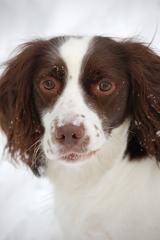

In [8]:
sample_img = PIL.Image.open(sample_fname); sample_img

In [ ]:
sample_img.size

# Filenames

In [ ]:
sample_fname.suffix

In [9]:
# recursively add suffixes in path to set
def build_suffixes(path, sfx=set()):
    if path.ls()[0].is_file():
        [sfx.add(x.suffix) for x in path.ls()]
    else:
        [build_suffixes(x, sfx) for x in path.ls()]
    return sfx

In [10]:
sfx = build_suffixes(path); sfx

{'.JPEG'}

In [11]:
# recursively add fnames in path to list
def get_filenames(path, fnames=[], sfx=None):
    if path.ls()[0].is_file():
        if sfx: 
            for x in path.ls():
                if x.suffix in sfx:
                    fnames.append(x)
        else: [fnames.append(x) for x in path.ls()]
    else:
        [get_filenames(x, fnames) for x in path.ls()]
    return fnames

In [12]:
fnames = get_filenames(path, [], sfx)
len(fnames)

13394

In [ ]:
fnames[:3]

In [ ]:
%timeit -n 10 get_filenames(path)

# Data

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

In [14]:
def make_RGB(x): return x.convert('RGB')
def resize_fixed(x, size): return x.resize((size,size), PIL.Image.BILINEAR)

In [30]:
tfms = transforms.Compose([
    make_RGB,
    partial(resize_fixed, size=128),
    transforms.ToTensor(),
    transforms.Normalize(m,s)   # this is added after initial dl creation off one batch
])

In [31]:
train_ds = datasets.ImageFolder((path/'train'), tfms)
val_ds = datasets.ImageFolder((path/'val'), tfms)

In [32]:
trn_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)

In [33]:
x,y = next(iter(trn_dl))

In [29]:
# normalization stats
m = x.mean((0,2,3))  # mean/channel
s = x.std((0,2,3))   # std/channel
m,s

(tensor([0.4546, 0.4545, 0.4292]), tensor([0.2845, 0.2760, 0.2925]))

In [34]:
# verify normalization
x.mean((0,2,3)), x.std((0,2,3))

(tensor([ 0.0280,  0.0043, -0.0469]), tensor([0.9789, 0.9987, 1.0337]))

In [35]:
data = DataBunch(trn_dl, val_dl, len(train_ds.classes))

# Model

In [36]:
# this needs to be in the global scope for CudaCallback to work.  Doh!

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [37]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [38]:
nfs = [3,16,32,64,64,64,128,256]

In [39]:
def get_cnn(nfs, classes):  
    layers = []
    for i in range(len(nfs)-1):
        stride = 1 if i==0 else 2
        layers.append(conv_layer(nfs[i], nfs[i+1], stride=stride))
    layers+=[nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], classes)]
    return nn.Sequential(*layers)

In [40]:
model = get_cnn(nfs, data.c)
init_cnn(model)

In [41]:
def summary(model, x):
    mods = model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: model(x)
        
summary(model, x)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

In [42]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [43]:
learn,run = get_runner(model, data, lr=0.2, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

In [44]:
%time run.fit(5, learn)

train: [1.8553711865693314, tensor(0.3543, device='cuda:0')]
valid: [1.981593351910828, tensor(0.3903, device='cuda:0')]
train: [1.436614812975235, tensor(0.5186, device='cuda:0')]
valid: [1.417638335987261, tensor(0.5322, device='cuda:0')]
train: [1.0837000384478297, tensor(0.6438, device='cuda:0')]
valid: [1.2913546228105095, tensor(0.5745, device='cuda:0')]
train: [0.7458054944093885, tensor(0.7645, device='cuda:0')]
valid: [1.1286963823646496, tensor(0.6364, device='cuda:0')]
train: [0.49879221423196746, tensor(0.8587, device='cuda:0')]
valid: [1.1184620073646496, tensor(0.6438, device='cuda:0')]
CPU times: user 33.2 s, sys: 11.7 s, total: 44.8 s
Wall time: 1min 5s
